In [1]:
# Only run this once
import os
os.chdir('..')

In [2]:
import numpy as np
import scipy
from scipy import signal
import mne
import glob
import HiguchiFractalDimension as hfd
import csv
import matplotlib.pyplot as plt
from matplotlib import colors

import utils.logger
from utils.experiments_classification import classify_nusvm_cross_valid, classify_nusvm_param_seach

In [3]:
import importlib
importlib.reload(utils.experiments_classification)

<module 'utils.experiments_classification' from 'D:\\etc\\uni\\yr5\\project\\workspace\\eeg-cnp-final-year-project\\utils\\experiments_classification.py'>

In [4]:
def patient_array_to_hfd(repetitions, window_start=None, window_size=500, step_size=1, k=7):
    '''
    Apply HFD to all repetitions from given patient; input shape [n_repetitions, n_channels, n_features]
    '''
    if window_start != None:
        print('Calculating HFD with window start', str(window_start), 'window size', str(window_size), 'step', str(step_size))
        return np.array([np.array([[hfd.hfd(channel[window_start:window_start+window_size:step_size], num_k=k)] for channel in repetition]) for repetition in repetitions])
    print('Calculating HFD over entire time series')
    return np.array([np.array([[hfd.hfd(channel, num_k=k)] for channel in repetition]) for repetition in repetitions])

# Apply HFD to datasets

In [5]:
# Returns relevant datasets (f.e. all right-hand recordings of healthy patients) as a list of np arrays
def get_datasets(patient_type_location, recording_type_expression):
    if recording_type_expression != l_new['extension']:
        sets_locations = glob.glob(patient_type_location + recording_type_expression + suffix)
    else:
        sets_locations = glob.glob(patient_type_location + recording_type_expression)
    
    sets = []
    for path in sets_locations: 
        sets.append(mne.io.read_epochs_eeglab(path))
        
    return np.array(np.array([(patient._data) for patient in sets]))


def get_channel_names(patient_type_location, recording_type_expression):
    '''
    Returns the list of channel names in order
    Only works if ALL chosen datasets use the same channels
    '''
    if recording_type_expression != l_new:
        sets_locations = glob.glob(patient_type_location + recording_type_expression + suffix)
    else:
        sets_locations = glob.glob(patient_type_location + recording_type_expression)
        
    return mne.io.read_epochs_eeglab(sets_locations[0]).ch_names
    

In [6]:
root = './../../'
suffix = '*.set'

location_healthy = root + 'data/raw/HV/*/'
location_pain = root + 'data/raw/PP/*/'
location_nopain = root + 'data/raw/PnP/*/'

location_pwp = root + 'data_new/raw/PwP/*/'
location_pdp = root + 'data_new/raw/PdP/*/'
location_pnp = root + 'data_new/raw/PnP/*/'


rh = {'name': 'RH', 'extension': '*_RH*'}
lh = {'name': 'LH', 'extension': '*_LH*'}
l_new = {'name': 'L', 'extension': '*_L.set'}   # NO SUFFIX
l_old = {'name': 'L', 'extension': '*_L_*'}

sets_healthy_rh = glob.glob(location_pdp + l_new['extension'])
sets_healthy_rh

['./../../data_new/raw/PdP\\PdP_3\\PdP_3_L.set',
 './../../data_new/raw/PdP\\PdP_4\\PdP_4_L.set',
 './../../data_new/raw/PdP\\PdP_5\\PdP_5_L.set',
 './../../data_new/raw/PdP\\PdP_6\\PdP_6_L.set',
 './../../data_new/raw/PdP\\PdP_7\\PdP_7_L.set']

In [103]:
limb = lh

pp_rh_raw = get_datasets(location_pain, limb['extension'])
pnp_rh_raw = get_datasets(location_nopain, limb['extension'])
hv_rh_raw = get_datasets(location_healthy, limb['extension'])

Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_LH_Removed_ICA.set...
56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP10\PP10_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


60 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP11\PP11_F1_LH_Removed_ICA.set...
60 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP2\PP2_F1_LH_Removed_ICA.set...
54 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP3\PP3_F1_LH_Removed_ICA.set...
51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP4\PP4_F1_LH_Removed_ICA.set...
58 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP5\PP5_F1_LH_Removed_ICA.set...
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP6\PP6_F1_LH_Removed_ICA.set...
27 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data/raw/PP\PP7\PP7_F1_LH_Removed_ICA.set...
53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP9\PP9_F1_LH_Removed_ICA.set...
51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data/raw/PnP\PnP1\PnP1_F1_LH_Removed_ICA.set...
51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP2\PnP2_F1_LH_Removed_ICA.set...
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data/raw/PnP\PnP3\PnP3_F1_LH_Removed_ICA.set...
43 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP4\PnP4_F1_LH_Removed_ICA.set...
57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data/raw/PnP\PnP5\PnP5_F1_LH_Removed_ICA.set...
54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP6\PnP6_F1_LH_Removed_ICA.set...
53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data/raw/PnP\PnP7\PnP7_F01_LH_Removed_ICA.set...
59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP8\PnP8_F1_LH_Removed_ICA.set...
58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data/raw/PnP\PnP9\PnP9_F1_LH_Removed_ICA.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/HV\HV1\HV1_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/HV\HV10\HV10_F1_LH_Removed_ICA.set...
51 matching events found
No baseline correction applied


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/HV\HV2\HV2_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/HV\HV3\HV3_F1_LH_Removed_ICA.set...
52 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/HV\HV4\HV4_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/HV\HV5\HV5_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/HV\HV6\HV6_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/HV\HV7\HV7_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/HV\HV8\HV8_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/HV\HV9\HV9_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


Alternatively, use all limbs

In [8]:
limb = {'name': 'all_limbs'}

pp_rh_raw = get_datasets(location_pain, rh['extension'])
pnp_rh_raw = get_datasets(location_nopain, rh['extension'])

pp_lh_raw = get_datasets(location_pain, lh['extension'])
pnp_lh_raw = get_datasets(location_nopain, lh['extension'])

pp_l_raw = get_datasets(location_pain, l_old['extension'])
pnp_l_raw = get_datasets(location_nopain, l_old['extension'])

Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_RH_Removed_ICA.set...
57 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP10\PP10_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP11\PP11_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP2\PP2_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP3\PP3_F1_RH_Removed_ICA.set...
51 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP4\PP4_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP5\PP5_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP6\PP6_F1_RH_Removed_ICA.set...
32 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data/raw/PP\PP7\PP7_F1_RH_Removed_ICA.set...
52 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP9\PP9_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP1\PnP1_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP2\PnP2_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP3\PnP3_F1_RH_Removed_ICA.set...
44 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP4\PnP4_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP5\PnP5_F1_RH_Removed_ICA.set...
50 matching events found
No baseline correction applied


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP6\PnP6_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP7\PnP7_F01_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP8\PnP8_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP9\PnP9_F1_RH_Removed_ICA.set...
54 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_LH_Removed_ICA.set...
56 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP10\PP10_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


60 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP11\PP11_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


60 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP2\PP2_F1_LH_Removed_ICA.set...
54 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP3\PP3_F1_LH_Removed_ICA.set...
51 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP4\PP4_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP5\PP5_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP6\PP6_F1_LH_Removed_ICA.set...
27 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data/raw/PP\PP7\PP7_F1_LH_Removed_ICA.set...
53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP9\PP9_F1_LH_Removed_ICA.set...
51 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP1\PnP1_F1_LH_Removed_ICA.set...
51 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP2\PnP2_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP3\PnP3_F1_LH_Removed_ICA.set...
43 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP4\PnP4_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP5\PnP5_F1_LH_Removed_ICA.set...
54 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP6\PnP6_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP7\PnP7_F01_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP8\PnP8_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP9\PnP9_F1_LH_Removed_ICA.set...
50 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP10\PP10_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP11\PP11_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP2\PP2_F1_L_Removed_ICA.set...
51 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP3\PP3_F1_L_Removed_ICA.set...
52 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP4\PP4_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP5\PP5_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP6\PP6_F1_L_Removed_ICA.set...
32 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data/raw/PP\PP7\PP7_F1_L_Removed_ICA.set...
52 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP9\PP9_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP1\PnP1_F1_L_Removed_ICA.set...
50 matching events found
No baseline correction applied


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP2\PnP2_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP3\PnP3_F1_L_Removed_ICA.set...
41 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data/raw/PnP\PnP4\PnP4_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP5\PnP5_F1_L_Removed_ICA.set...
50 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP6\PnP6_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP7\PnP7_F01_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP8\PnP8_F1_L_Removed_ICA.set...
50 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP9\PnP9_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


In [10]:
pp_all_limbs = np.concatenate((pp_rh_raw, pp_lh_raw, pp_l_raw))
pnp_all_limbs = np.concatenate((pnp_rh_raw, pnp_lh_raw, pnp_l_raw))

In [11]:
pnp_all_limbs.shape

(23,)

In [8]:
ch_names_new = get_channel_names(location_pdp, rh['extension'])
ch_names_new

Extracting parameters from ./../../data_new/raw/PdP\PdP_1\PdP_1_RH.set...
65 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:25: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  return mne.io.read_epochs_eeglab(sets_locations[0]).ch_names


['Fp1',
 'Fpz',
 'Fp2',
 'F7',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F8',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'FC6',
 'T7',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'CP5',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'CP6',
 'P7',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO3',
 'POz',
 'PO4',
 'O1',
 'Oz',
 'O2',
 'FC5']

In [9]:
ch_names = get_channel_names(location_pain, rh['extension'])
ch_names

Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:25: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  return mne.io.read_epochs_eeglab(sets_locations[0]).ch_names


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


['Cz',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'FCz',
 'FC1',
 'FC2',
 'FC3',
 'FC4',
 'FC5',
 'FC6',
 'FT7',
 'FT8',
 'CPz',
 'CP1',
 'CP2',
 'CP3',
 'CP4',
 'CP5',
 'CP6',
 'TP7',
 'TP8',
 'Fz',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'Pz',
 'P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'AFz',
 'AF3',
 'AF4',
 'AF7',
 'AF8',
 'Fp1',
 'FP2',
 'POz',
 'PO3',
 'PO4',
 'PO7',
 'PO8',
 'Oz',
 'O1',
 'O2',
 'Iz']

In [10]:
# Check for any channels not present in both
#for ch in ch_names_new:
#    if not (ch in ch_names):
 #       print(ch, end=' ')

In [11]:
pp_rh_raw.shape

(7,)

In [12]:
pp_rh_raw[4][3].shape

(48, 1280)

Get HFD over the set time window

In [13]:
window_start_sec = 3
window_size = 2
freq = 250

k = 7

In [13]:
pp_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in pp_rh_raw])
pnp_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in pnp_rh_raw])

Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1


OR get HFD for all limbs

In [102]:
pp_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in pp_all_limbs])
pnp_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in pnp_all_limbs])
#hv_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in hv_rh_limbs])

NameError: name 'pp_all_limbs' is not defined

Alternatively, get HFD over all windows of the specified size

In [104]:
pp_all_windows = [[patient_array_to_hfd(patient, window_start=window*freq, window_size=window_size*freq, k=k) for patient in pp_rh_raw] for window in range(0,4)]
pnp_all_windows = [[patient_array_to_hfd(patient, window_start=window*freq, window_size=window_size*freq, k=k) for patient in pnp_rh_raw] for window in range(0,4)]
hv_all_windows = [[patient_array_to_hfd(patient, window_start=window*freq, window_size=window_size*freq, k=k) for patient in hv_rh_raw] for window in range(0,4)]

Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window

In [105]:
np_all = np.array(pp_all_windows)

In [106]:
np.sum([s.shape[0] for s in np_all[0]])

525

In [107]:
pnp_rh.shape

NameError: name 'pnp_rh' is not defined

In [109]:
# Over individual patients
pp_all_windows_patients_repetitions = np.array([[np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ] for window in np.array(pp_all_windows) ])
pnp_all_windows_patients_repetitions = np.array([[np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ] for window in np.array(pnp_all_windows) ])
hv_all_windows_patients_repetitions = np.array([[np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ] for window in np.array(hv_all_windows) ])

pnp_all_windows_patients_repetitions.shape

(4, 9)

In [110]:
# All repetitions concatenated
pp_all_windows_repetitions = np.array([np.vstack([np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ]) for window in np.array(pp_all_windows) ])
pnp_all_windows_repetitions = np.array([np.vstack([np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ]) for window in np.array(pnp_all_windows) ])
hv_all_windows_repetitions = np.array([np.vstack([np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ]) for window in np.array(hv_all_windows) ])

pnp_all_windows_repetitions.shape

(4, 480, 61)

In [111]:
pp_mean_all_windows = np.mean(pp_all_windows_repetitions, axis=1).transpose()
pnp_mean_all_windows = np.mean(pnp_all_windows_repetitions, axis=1).transpose()
hv_mean_all_windows = np.mean(hv_all_windows_repetitions, axis=1).transpose()

pnp_mean_all_windows.shape

(61, 4)

In [112]:
diff_pp_pnp_all_windows = pp_mean_all_windows - pnp_mean_all_windows
diff_pp_pnp_all_windows = diff_pp_pnp_all_windows - diff_pp_pnp_all_windows.mean()

diff_hv_pnp_all_windows = hv_mean_all_windows - pnp_mean_all_windows
diff_hv_pnp_all_windows = diff_hv_pnp_all_windows - diff_hv_pnp_all_windows.mean()

diff_hv_pp_all_windows = hv_mean_all_windows - pp_mean_all_windows
diff_hv_pp_all_windows = diff_hv_pp_all_windows - diff_hv_pp_all_windows.mean()

In [75]:
scipy.io.savemat('./results/arrays/hfd_2s_window_means_l.mat', {'pp': pp_mean_all_windows, 'pnp': pnp_mean_all_windows, 'hv': hv_mean_all_windows,
                                                                'diff_pp_pnp': diff_pp_pnp_all_windows, 'diff_hv_pnp': diff_hv_pnp_all_windows,
                                                                'diff_hv_pp': diff_hv_pp_all_windows})

In [34]:
scipy.io.savemat('./results/arrays/hfd_2s_window_individuals_lh.mat', {'pp': pp_all_windows_patients_repetitions, 'pnp': pnp_all_windows_patients_repetitions, 'hv': hv_all_windows_patients_repetitions,})

In [55]:
scipy.io.savemat('./results/arrays/hfd_2s_window_repetitions_l.mat', {'pp': pp_all_windows_repetitions, 'pnp': pnp_all_windows_repetitions, 'hv': hv_all_windows_repetitions,})

In [86]:
scipy.io.savemat('./results/arrays/pdp_hfd_2s_window_means_l.mat', {'pdp': pp_mean_all_windows, 'pnp': pnp_mean_all_windows,
                                                                'diff_pp_pnp': diff_pp_pnp_all_windows})

In [87]:
scipy.io.savemat('./results/arrays/pdp_hfd_2s_window_individuals_l.mat', {'pdp': pp_all_windows_patients_repetitions, 'pnp': pnp_all_windows_patients_repetitions})

In [88]:
scipy.io.savemat('./results/arrays/pdp_hfd_2s_window_repetitions_l.mat', {'pdp': pp_all_windows_repetitions, 'pnp': pnp_all_windows_repetitions})

In [100]:
testtt = scipy.io.loadmat('./results/arrays/pdp_hfd_2s_window_repetitions_l.mat')

In [21]:
testtt['pdp'].shape

NameError: name 'testtt' is not defined

In [22]:
(testtt['pdp'] - testtt['pnp']) - (testtt['pdp'] - testtt['pnp']).mean() - testtt['diff_pp_pnp']

NameError: name 'testtt' is not defined

In [113]:
diff_all_windows = pp_mean_all_windows - pnp_mean_all_windows
diff_all_windows = diff_all_windows - diff_all_windows.mean()
diff_all_windows.shape

(61, 4)

In [114]:
scipy.stats.normaltest(diff_all_windows.flatten())

NormaltestResult(statistic=2.5280177927926215, pvalue=0.28251916318974224)

In [115]:
max_hfd = np.max([np.max(pp_all_windows_repetitions), np.max(pnp_all_windows_repetitions)])
min_hfd = np.min([np.min(pp_all_windows_repetitions), np.min(pnp_all_windows_repetitions)])

In [116]:
np.max(pp_all_windows_repetitions)

1.9819319755713867

In [117]:
np.mean(pp_all_windows_repetitions, axis=1).transpose()[14][1]

1.8302081964838588

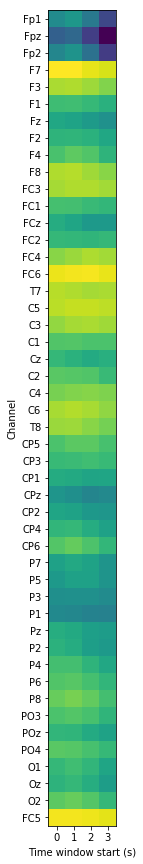

In [84]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PDP; k=7'
graph_name = 'window_pdp_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel')
plt.yticks(ticks=range(48), labels=ch_names_new)
plt.xticks(range(4))
plt.xlabel('Time window start (s)')
plt.imshow(pp_mean_all_windows)
plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.jpg')

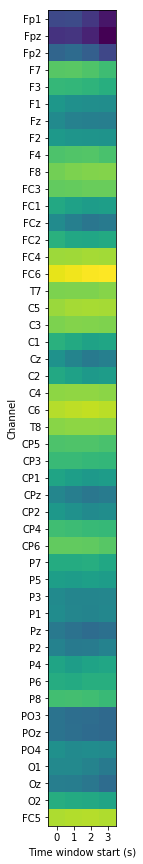

In [85]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PNP; k=7'
graph_name = 'window_pnp_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel')
plt.yticks(ticks=range(48), labels=ch_names_new)
plt.xticks(range(4))
plt.xlabel('Time window start (s)')
plt.imshow(pnp_mean_all_windows)
plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.jpg')

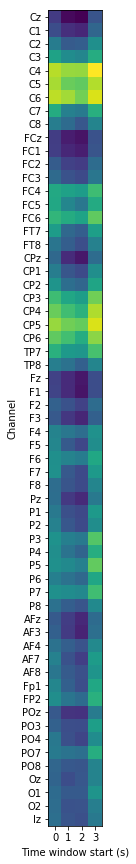

In [91]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PNP; k=7'
graph_name = 'window_hv_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel')
plt.yticks(ticks=range(61), labels=ch_names)
plt.xticks(range(4))
plt.xlabel('Time window start (s)')
plt.imshow(hv_mean_all_windows)
plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.jpg')

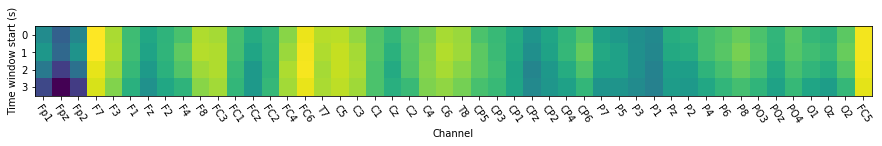

In [86]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PDP; k=7'
graph_name = 'window_pdp_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel')
plt.xticks(ticks=range(48), labels=ch_names_new, rotation=-55)
plt.yticks(range(4))
plt.ylabel('Time window start (s)')
plt.imshow(pp_mean_all_windows.transpose())
plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.jpg')

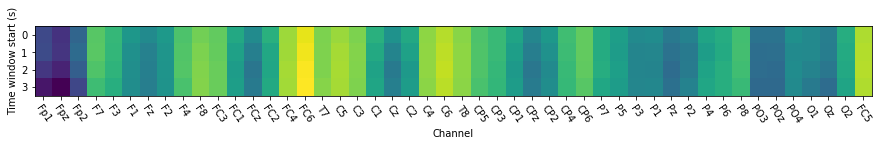

In [87]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PNP; k=7'
graph_name = 'window_pnp_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel')
plt.xticks(ticks=range(48), labels=ch_names_new, rotation=-55)
plt.yticks(range(4))
plt.ylabel('Time window start (s)')
plt.imshow(pnp_mean_all_windows.transpose())
plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.jpg')

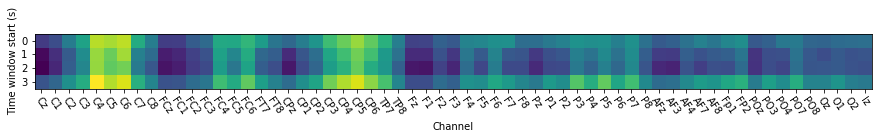

In [94]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PNP; k=7'
graph_name = 'window_hv_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel')
plt.xticks(ticks=range(61), labels=ch_names, rotation=-55)
plt.yticks(range(4))
plt.ylabel('Time window start (s)')
plt.imshow(hv_mean_all_windows.transpose())
plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.jpg')

In [ ]:
diff_all_windows[ch_names.index('P1')]

In [ ]:
diff_all_windows.min()

In [ ]:
asda = np.abs(diff_all_windows - np.zeros(diff_all_windows.shape))
np.unravel_index(asda.argmin(), asda.shape)

In [ ]:
ch_names[20]

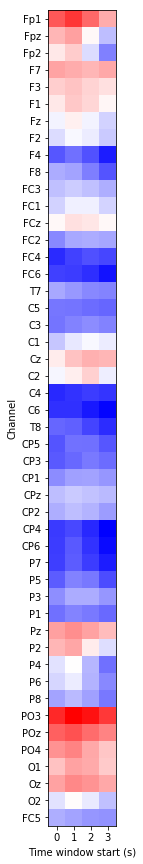

In [88]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_pdp_pnp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel')
plt.yticks(ticks=range(48), labels=ch_names_new)
plt.xticks(range(4))
plt.xlabel('Time window start (s)')
plt.imshow(diff_pp_pnp_all_windows, cmap='bwr')

plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.jpg')

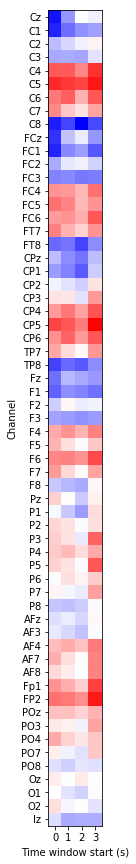

In [100]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_hv_pp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel')
plt.yticks(ticks=range(61), labels=ch_names)
plt.xticks(range(4))
plt.xlabel('Time window start (s)')
plt.imshow(diff_hv_pp_all_windows, cmap='bwr')

plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.jpg')

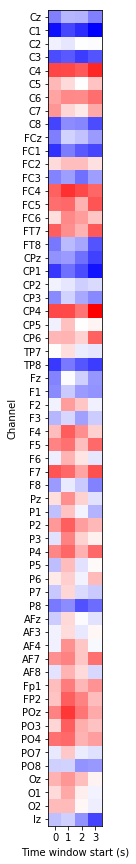

In [101]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_hv_pnp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel')
plt.yticks(ticks=range(61), labels=ch_names)
plt.xticks(range(4))
plt.xlabel('Time window start (s)')
plt.imshow(diff_hv_pnp_all_windows, cmap='bwr')

plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/v/' + limb['name'] + '/' + graph_name + '.jpg')

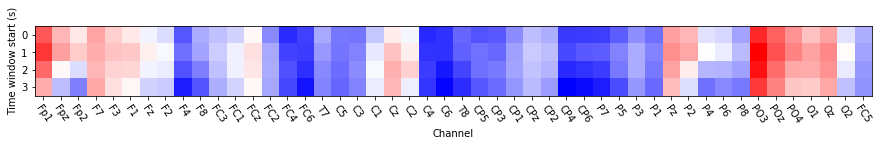

In [89]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_pdp_pnp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel')
plt.xticks(ticks=range(48), labels=ch_names_new, rotation=-55)
plt.yticks(range(4))
plt.ylabel('Time window start (s)')
plt.imshow(diff_pp_pnp_all_windows.transpose(), cmap='bwr')

plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.jpg')

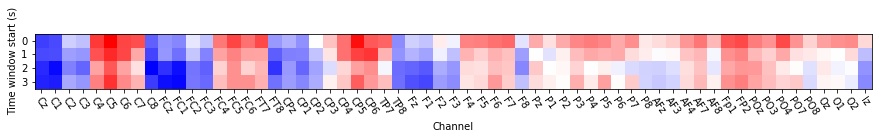

In [118]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_hv_pp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel')
plt.xticks(ticks=range(61), labels=ch_names, rotation=-55)
plt.yticks(range(4))
plt.ylabel('Time window start (s)')
plt.imshow(diff_hv_pp_all_windows.transpose(), cmap='bwr')

plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.jpg')

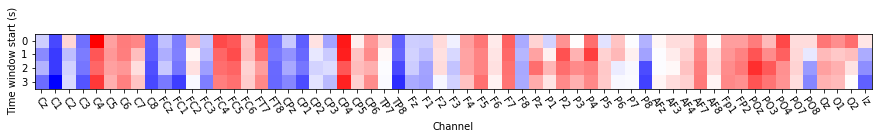

In [119]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_hv_pnp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel')
plt.xticks(ticks=range(61), labels=ch_names, rotation=-55)
plt.yticks(range(4))
plt.ylabel('Time window start (s)')
plt.imshow(diff_hv_pnp_all_windows.transpose(), cmap='bwr')

plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.eps')
plt.savefig('./results/graphs/no_captions/h/' + limb['name'] + '/' + graph_name + '.jpg')

In [22]:
pnp_rh[0].shape

(56, 48, 1)

In [23]:
pp_rh[3].shape

(58, 48, 1)

In [24]:
pp_and_pnp = np.concatenate((pp_rh, pnp_rh))
pp_and_pnp.shape

(14,)

# It's time to learn

In [14]:
log_proc_method = 'HFD'
log_dataset = 'PDP/PNP-' + limb['name']
log_db_name = 'log.db'

log_notes = {'window start': window_start_sec, 'window size': window_size, 'k': k}

In [15]:
print(log_dataset)
print(log_notes)

PDP/PNP-L
{'window start': 3, 'window size': 2, 'k': 7}


In [18]:
#For finding channel indices

channel_names_to_find = ['F2']

find_in_pdp = True

for c in channel_names_to_find:
    if find_in_pdp:
        print(ch_names_new.index(c))
    else:
        print(ch_names.index(c))
        

7


In [20]:
ch_names_new[7]

'F2'

In [23]:
nu = 0.325
channels = [12]

acc, sensitivity, specificity, avg_acc = classify_nusvm_cross_valid(pp_rh, pnp_rh, nu, channels, ch_names_new,
                                                                    log_db_name=log_db_name,
                                                                    log_txt=True,
                                                                    log_proc_method=log_proc_method,
                                                                    log_dataset=log_dataset,
                                                                    log_notes=log_notes,
                                                                    log_details=False
                                                                   )
print('Accuracy', acc)
print('Sensitivity', sensitivity)
print('Specificity', specificity)
print('Average accuracy', avg_acc)

Test index 0 Preparing to classify set of 348 PP and 379 PNP.
Train score: 0.5075653370013755   Test score: 1.0
Test index 1 Preparing to classify set of 345 PP and 379 PNP.
Train score: 0.585635359116022   Test score: 0.9117647058823529
Test index 2 Preparing to classify set of 356 PP and 379 PNP.
Train score: 0.5428571428571428   Test score: 0.9473684210526315
Test index 3 Preparing to classify set of 355 PP and 379 PNP.
Train score: 0.6062670299727521   Test score: 0.7931034482758621
Test index 4 Preparing to classify set of 361 PP and 379 PNP.
Train score: 0.3256756756756757   Test score: 0.8461538461538461
Test index 5 Preparing to classify set of 359 PP and 379 PNP.
Train score: 0.508130081300813   Test score: 1.0
Test index 6 Preparing to classify set of 354 PP and 379 PNP.
Train score: 0.48567530695770805   Test score: 0.0
Test index 7 Preparing to classify set of 413 PP and 323 PNP.
Train score: 0.5461956521739131   Test score: 0.0
Test index 8 Preparing to classify set of 413

In [ ]:
previous_channels=[7]
nu = 0.15

max_acc = {'index': 0, 'value': 0}
for channel in range(61):        
    accuracy, sensitivity, specificity, avg_accuracy = classify_nusvm_cross_valid(pp_rh, pnp_rh, nu, 
                                                                                  previous_channels + [channel], 
                                                                                  verbose=False,
                                                                                  log_db_name=log_db_name,
                                                                                  log_txt=True,
                                                                                  log_proc_method=log_proc_method,
                                                                                  log_dataset=log_dataset,
                                                                                  log_notes=log_notes
                                                                                 )
    print(channel, accuracy, sensitivity, specificity, avg_accuracy)
        
    if accuracy > max_acc['value']:
        max_acc['index'] = channel
        max_acc['value'] = accuracy

print('Max accuracy:', max_acc['index'], max_acc['value'])

In [21]:
channels = [7]

max_acc = {'index': 0, 'value': 0}
for param in np.arange(0.1, 0.8, 0.025):    
    accuracy, sensitivity, specificity, avg_accuracy = classify_nusvm_cross_valid(pp_rh, pnp_rh, param,
                                                                                  channels,
                                                                                  ch_names_new,
                                                                                  verbose=False, 
                                                                                  log_db_name=log_db_name,
                                                                                  log_txt=True,
                                                                                  log_proc_method=log_proc_method,
                                                                                  log_dataset=log_dataset,
                                                                                  log_notes=log_notes
                                                                                 ) 
                                                      

    print(param, accuracy, sensitivity, specificity, avg_accuracy)
        
    if accuracy > max_acc['value']:
        max_acc['index'] = param
        max_acc['value'] = accuracy

        
print('Max accuracy:', max_acc['index'], max_acc['value'])

0.1 0.2700617283950617 0.3225806451612903 0.23035230352303523 0.26063072028356
0.125 0.4799382716049383 0.7777777777777778 0.25474254742547425 0.4760025865396815
0.15 0.4089506172839506 0.4982078853046595 0.34146341463414637 0.40130260415348135
0.175 0.5246913580246914 0.7849462365591398 0.32791327913279134 0.5107279594723843
0.19999999999999998 0.6265432098765432 0.7347670250896058 0.5447154471544715 0.6084180413726206
0.22499999999999998 0.5540123456790124 0.5519713261648745 0.5555555555555556 0.5423756149633342
0.24999999999999997 0.47685185185185186 0.03225806451612903 0.8130081300813008 0.4852805414208922
0.27499999999999997 0.720679012345679 0.6093189964157706 0.8048780487804879 0.715864049855278
0.29999999999999993 0.5540123456790124 0.20430107526881722 0.8184281842818428 0.5660807552858921
0.32499999999999996 0.4583333333333333 0.41935483870967744 0.4878048780487805 0.4510943595864055
0.35 0.5216049382716049 0.3978494623655914 0.6151761517615176 0.5220639656623153
0.37499999999

ValueError: specified nu is infeasible

In [32]:
channel_names = ch_names_new if 'PDP' in log_dataset else ch_names

best_acc = classify_nusvm_param_seach(pp_rh, pnp_rh, 0.1, 0.8, 0.025, channel_names, constrain_channels=None,
                                      log_txt=True, log_proc_method=log_proc_method,
                                                                                  log_dataset=log_dataset,
                                                                                  log_notes=log_notes)

nu: 0.1
[6] 0.76
[6] 0.76
Max Accuracy: {'channels': [6], 'value': 0.7631578947368421, 'nu': 0.1}
nu: 0.125
[8] 0.77
[8] 0.77
Max Accuracy: {'channels': [8], 'value': 0.7690058479532164, 'nu': 0.125}
nu: 0.15
[44] 0.75
[44, 39] 0.75
[44, 39] 0.75
Max Accuracy: {'channels': [8], 'value': 0.7690058479532164, 'nu': 0.125}
nu: 0.175
[32] 0.73
[32, 12] 0.77
[32, 12] 0.77
Max Accuracy: {'channels': [32, 12], 'value': 0.7733918128654971, 'nu': 0.175}
nu: 0.19999999999999998
[19] 0.75
[19, 31] 0.81
[19, 31, 9] 0.81
[19, 31, 9] 0.81
Max Accuracy: {'channels': [19, 31, 9], 'value': 0.8084795321637427, 'nu': 0.19999999999999998}
nu: 0.22499999999999998
[29] 0.70
[29, 12] 0.71
[29, 12, 15] 0.76
[29, 12, 15, 6] 0.82
[29, 12, 15, 6] 0.82
Max Accuracy: {'channels': [29, 12, 15, 6], 'value': 0.8245614035087719, 'nu': 0.22499999999999998}
nu: 0.24999999999999997
[10] 0.69
[10] 0.69
Max Accuracy: {'channels': [29, 12, 15, 6], 'value': 0.8245614035087719, 'nu': 0.22499999999999998}
nu: 0.2749999999999999

Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.7249999999999999 is infeasible.
Nu value 0.

In [ ]:
best_acc